### EDA

In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings("ignore")
from matplotlib import rc
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

## 0. Data Extract

In [2]:
# Aws connect settings
endpoint = "localhost"
port = 5432
database_name = "postgres"
username = "woolee"
password = "postgres"

# Establish a connection
try:
    connection = psycopg2.connect(
        host=endpoint,
        port=port,
        dbname=database_name,
        user=username,
        password=password
    )
    print("Connected to the PostgreSQL database on AWS RDS")
    cursor = connection.cursor()

except psycopg2.Error as error:
    print("Error connecting to the PostgreSQL database on AWS RDS:", error)

Connected to the PostgreSQL database on AWS RDS


In [3]:
iasset_view = pd.read_csv("../asset/igisbiz/iasset_view_202408.csv")
ibene_view = pd.read_csv("../asset/igisbiz/ibene_view_202408.csv")
ifundaum_view = pd.read_csv("../asset/igisbiz/ifundaum_view_202408.csv")
ifundaum_aureum = pd.read_csv("../asset/igisbiz/ifundaum_aureum_202408.csv")
ilend_view = pd.read_csv("../asset/igisbiz/ilend_view_202408.csv")
market_market = pd.read_csv("../asset/igisbiz/market_market_202408.csv", dtype={'pnu': str})
market_tenant = pd.read_csv("../asset/igisbiz/market_tenant_202408.csv", dtype={'pnu': str})

### 데이터 추출

In [4]:
bds_query = """
SELECT 
    *
FROM 
    pantera.bds;
"""
# 쿼리 실행 및 결과를 데이터프레임으로 변환

bds = pd.read_sql(bds_query, connection)

### 데이터 병합(Right Join): x, y추가, bds 추가

In [5]:
pnus = list(iasset_view.pnu)
xs = []
ys = []
for pnu in pnus:
    try:
        query = f"SELECT x,y FROM bddb.jibunaddress WHERE pnu='{pnu}'"
        cursor.execute(query)
        results = cursor.fetchall()
        x, y = results[0]
        x, y = float(x), float(y)
        
    except:
        x, y = 0, 0
    xs.append(x)
    ys.append(y)

iasset_view['x'] = xs
iasset_view['y'] = ys

In [6]:
bds_use_cols = ['pnu',  'ilp',  'x', 'y', 'vintageyr', 'x_5179', 'y_5179',  'stdr_yyyy', 
'busmetromms', 'totarearank', 'ilprank', 'vintageyrrank', 'salaryrank',
'metrorank', 'busrank', 'corpfinrank', 'busmetrorank', 'district_nm',
'bds'
]

In [7]:
iassetview_bds = pd.merge(iasset_view, bds[bds_use_cols][bds['stdr_yyyy'] == '2023'], on='pnu', how='left')

## 1. Asset EDA

### EDA 1. 이지스가 직간접적으로 투자하고 있는 펀드의 자산의 현황 - 투자자산유형별/국내해외구분별 및 주소데이터 결측률

In [8]:
cond = iasset_view['운용상태'] == '운용'
filtered_df = iasset_view[cond]
grouped_df = filtered_df.groupby('투자자산유형').size().reset_index(name='갯수')
total_count = grouped_df['갯수'].sum()
print("총 갯수:", total_count)
grouped_df['비율(%)'] = (grouped_df['갯수'] / total_count) * 100
grouped_df.sort_values(by='갯수', ascending=False)

총 갯수: 677


,투자자산유형,갯수,비율(%)
13,특별자산,126,18.611521
10,오피스,99,14.623338
12,지분증권,79,11.669129
7,복합(오피스),78,11.521418
5,물류,67,9.896603
11,주거,64,9.453471
4,리테일,41,6.056130
1,기타,39,5.760709
14,호텔,24,3.545052
2,대출채권,18,2.658789


1.1. 운용중 자산: 당사 운용중 자산(개수 기준)중 특별자산이 가장 많았으며 오피스가 뒤따랐다

In [9]:
grouped_df = filtered_df.groupby('국내해외구분명').size().reset_index(name='갯수')
total_count = grouped_df['갯수'].sum()
print("총 갯수:", total_count)
grouped_df['비율(%)'] = (grouped_df['갯수'] / total_count) * 100
grouped_df.sort_values(by='갯수', ascending=False)

총 갯수: 678


,국내해외구분명,갯수,비율(%)
0,국내,477,70.353982
1,해외,199,29.351032
2,혼합,2,0.294985


1.1. 운용중 자산: 당사 운용중 자산(개수 기준)의 70%가 국내, 그 외가 해외에 소재해있다

In [10]:
cond = iasset_view['운용상태'] == '청산'
filtered_df = iasset_view[cond]
grouped_df = filtered_df.groupby('투자자산유형').size().reset_index(name='갯수')
total_count = grouped_df['갯수'].sum()
print("총 갯수:", total_count)
grouped_df['비율(%)'] = (grouped_df['갯수'] / total_count) * 100
grouped_df.sort_values(by='갯수', ascending=False)

총 갯수: 191


,투자자산유형,갯수,비율(%)
7,오피스,44,23.036649
3,리테일,30,15.706806
5,복합(오피스),28,14.659686
8,주거,26,13.612565
4,물류,19,9.947644
10,특별자산,16,8.376963
11,호텔,9,4.712042
0,NPL,6,3.141361
1,기타,5,2.617801
2,데이터센터,5,2.617801


1.2. 청산한 자산: 당사 청산한 자산(개수 기준)은 오피스, 리테일, 복합(오피스)순이며 이 세 유형이 과반을 차지한다

In [11]:
grouped_df = filtered_df.groupby('국내해외구분명').size().reset_index(name='갯수')
total_count = grouped_df['갯수'].sum()
print("총 갯수:", total_count)
grouped_df['비율(%)'] = (grouped_df['갯수'] / total_count) * 100
grouped_df.sort_values(by='갯수', ascending=False)

총 갯수: 191


,국내해외구분명,갯수,비율(%)
0,국내,146,76.439791
1,해외,45,23.560209


1.2. 청산한 자산: 당사 청산한 자산(개수 기준)은 76%은 국내자산이다. 현재 운용중인 자산 비율과 큰 차이가 없다

### EDA 2. 공실률, NOI

In [12]:
explore_col = ['공실률(%)']
view_cols = ["펀드코드", "약칭", "투자자산유형", "자산코드", "자산명", "platplc"]

In [13]:
iasset_view_ = iasset_view.drop_duplicates(subset='자산코드', keep='first')

topn_vacancy = iasset_view_[iasset_view_['공실률(%)']>0]
topn_vacancy[view_cols + explore_col].sort_values(by = '공실률(%)', ascending=False)

,펀드코드,약칭,투자자산유형,자산코드,자산명,platplc,공실률(%)
71,112059,61호,오피스,A112059001,수송스퀘어,서울특별시 종로구 수송동 83-1,100.00
539,112539,386호,복합(오피스),A112539001,Hawaii Sky Ala Moana Senior B-note Loan,NoData,100.00
171,112170,148-1호,오피스,A112170001,Jakarta Office Treasury Tower,NoData,100.00
557,112560,401호,복합(오피스),A112560001,Manhattan Meatpacking Plaza Senior + Mezz Loan,NoData,100.00
15,112012,16호,오피스,A112012001,동일타워,서울특별시 강남구 대치동 1004,71.00
104,112096,104호,오피스,A112096001,T타워,서울특별시 중구 남대문로5가 827,55.10
128,112128,코어1호,지분증권,A112139001,시그니쳐타워,서울특별시 중구 수표동 99,52.50
94,112086,90호,오피스,A112086001,신도림핀포인트,서울특별시 구로구 신도림동 337,33.80
67,112055,59호,오피스,A112055001,씨티플라자,서울특별시 영등포구 여의도동 25,24.20
721,112694,463-1호(1종),지분증권,A112694001,이지스제463호부동산일반사모투자회사,서울특별시 중구 남대문로5가 581,22.59


2.1. 공실률: 당사 자산의 공실률(%)이 0보다 큰 자산은 아래와 같다. 자산개수 기준으로 국내/해외 비율이 7/3인 것을 고려하면, 해외자산이 비교적 공실률이 높은 편인 것으로 관측된다.

In [14]:
iasset_view_ = iasset_view.copy()
iasset_view_ = iasset_view_.drop_duplicates(subset='자산코드', keep='first')

iasset_view_['NOI'] = iasset_view_['NOI'].fillna(0).astype(int)
# iasset_view_['NOIdivPY'] = iasset_view_['NOI'] / iasset_view_['평'] * 2
explore_col = ['NOI']
view_cols = ["펀드코드", "약칭", "투자자산유형", "자산코드", "자산명", "platplc",  "pnu"]

In [15]:
iasset_view_[view_cols + explore_col].sort_values(by = 'NOI', ascending=False).head(20)

,펀드코드,약칭,투자자산유형,자산코드,자산명,platplc,pnu,NOI
479,112500,인컴앤그로스 2호,복합(오피스),A112721001,인천석남물류센터,인천광역시 서구 석남동 224-8,2826011000102240008,29775052000
754,112751,인컴앤그로스2의4호,물류,A112751001,인천석남물류센터,인천광역시 서구 석남동 224-8,2826011000102240008,29775052000
122,112118,124호,오피스,A112118001,LS용산타워,서울특별시 용산구 한강로2가 191,1117012500101910000,29237245785
726,112700,400호,오피스,A112700001,여의도 신한금융투자타워,서울특별시 영등포구 여의도동 23-2,1156011000100230002,22500000000
126,112127,116호,물류,A112127001,아레나스양지물류센터,경기도 용인시 처인구 양지면 양지리 914,4146136021109140000,21900000000
65,112054,55호,리테일,A112054002,롯데마트(제주),제주특별자치도 제주시 노형동 708,5011012200107080000,16800000000
66,112054,55호,리테일,A112054003,롯데팩토리아울렛(인천),인천광역시 중구 항동7가 76-2,2811011800100760002,16800000000
21,112018,19호,리테일,A112018001,홈플러스삼천포점,경상남도 사천시 벌리동 58-3,4824010800100580003,14100000000
46,112037,30호,리테일,A112037001,롯데수원역쇼핑타운토지,경기도 수원시 권선구 서둔동 296-77,4111313100102960077,13600000000
465,112490,389호,리테일,A112490001,롯데백화점분당점,경기도 성남시 분당구 수내동 14,4113510200100140000,13320999000


2.2. NOI: 대형 오피스, 대형 리테일 위 주로 높은 NOI를 보인다

In [16]:
cond1 = iasset_view_['투자자산유형'] == '오피스'
cond2 = iasset_view_['NOI']>0
iasset_view_[cond1&cond2][view_cols + explore_col].sort_values(by = 'NOI', ascending=False).head(6)

,펀드코드,약칭,투자자산유형,자산코드,자산명,platplc,pnu,NOI
122,112118,124호,오피스,A112118001,LS용산타워,서울특별시 용산구 한강로2가 191,1117012500101910000,29237245785
726,112700,400호,오피스,A112700001,여의도 신한금융투자타워,서울특별시 영등포구 여의도동 23-2,1156011000100230002,22500000000
558,112561,424호,오피스,A112561001,역삼AP타워,서울특별시 강남구 역삼동 719-1,1168010100107190001,6006555031
475,112499,인컴앤그로스2-1호,오피스,A112499001,선릉위워크타워,서울특별시 강남구 역삼동 706,1168010100107060026,5602900000
94,112086,90호,오피스,A112086001,신도림핀포인트,서울특별시 구로구 신도림동 337,1153010100103370000,3711027000
674,112649,부산특구1호,오피스,A112649001,B스퀘어,부산광역시 부산진구 범천동 863-1,2623010400108630001,1653000000


2.2. NOI: [오피스]의 경우 LS용산타워 -> 신한금융투자타워 -> 역삼AP 타워순으로 높다. 3대 업무지구+용산 제외하고는 신도림에 위치한 신도림핀포인트의 NOI가 높은 편임을 주목할 수 있다

In [17]:
cond1 = iasset_view_['투자자산유형'] == '리테일'
cond2 = iasset_view_['NOI']>0
iasset_view_[cond1&cond2][view_cols + explore_col].sort_values(by = 'NOI', ascending=False).head(8)

,펀드코드,약칭,투자자산유형,자산코드,자산명,platplc,pnu,NOI
65,112054,55호,리테일,A112054002,롯데마트(제주),제주특별자치도 제주시 노형동 708,5011012200107080000,16800000000
66,112054,55호,리테일,A112054003,롯데팩토리아울렛(인천),인천광역시 중구 항동7가 76-2,2811011800100760002,16800000000
21,112018,19호,리테일,A112018001,홈플러스삼천포점,경상남도 사천시 벌리동 58-3,4824010800100580003,14100000000
46,112037,30호,리테일,A112037001,롯데수원역쇼핑타운토지,경기도 수원시 권선구 서둔동 296-77,4111313100102960077,13600000000
465,112490,389호,리테일,A112490001,롯데백화점분당점,경기도 성남시 분당구 수내동 14,4113510200100140000,13320999000
300,112311,287호,리테일,A112311001,목동 트라팰리스 스퀘어,서울특별시 양천구 목동 962,1147010200109620000,5152742000
55,112047,48호,리테일,A112047001,남악신도시 복합쇼핑몰,전라남도 무안군 삼향읍 남악리 2622,4684025622126220001,4500000000
340,112365,299호,리테일,A112365001,CGV대학로,서울특별시 종로구 명륜2가 41-9,1111017100100410009,2862512177


2.2. NOI: [리테일]의 경우 대형마트, 아울렛 위주로 높다. 서울특별시에서는 목동 트라팰리스 스퀘어가 가장 높은 NOI를 보인다.

In [18]:
cond1 = iasset_view_['투자자산유형'] == '복합(오피스)'
cond2 = iasset_view_['NOI']>0
iasset_view_[cond1&cond2][view_cols + explore_col].sort_values(by = 'NOI', ascending=False).head(5)

,펀드코드,약칭,투자자산유형,자산코드,자산명,platplc,pnu,NOI
479,112500,인컴앤그로스 2호,복합(오피스),A112721001,인천석남물류센터,인천광역시 서구 석남동 224-8,2826011000102240008,29775052000
224,112237,스트래티직 1호,복합(오피스),A112350001,타임워크명동,서울특별시 중구 명동1가 59-5,1114012600100590005,13265000000
225,112237,스트래티직 1호,복합(오피스),A112290001,타임테라스동탄,경기도 화성시 반송동 96,4159012700100960000,11753835044
477,112500,인컴앤그로스 2호,복합(오피스),A112500002,평택아디다스물류센터,경기도 평택시 도일동 1175-3,4122010600111750003,4156551163
294,112305,279호,복합(오피스),A112305001,금강타워3,서울특별시 강남구 삼성동 154-8,1168010500101540008,2528171058


2.2. NOI: [복합(오피스)]의 NOI Top10은 위와 같다. 서울특별시에서는 타임워크명동, 금강타워3 순으로 높은 NOI를 보인다

In [19]:
cond1 = iasset_view_['투자자산유형'] == '물류'
cond2 = iasset_view_['NOI']>0
iasset_view_[cond1&cond2][view_cols + explore_col].sort_values(by = 'NOI', ascending=False).head(5)

,펀드코드,약칭,투자자산유형,자산코드,자산명,platplc,pnu,NOI
754,112751,인컴앤그로스2의4호,물류,A112751001,인천석남물류센터,인천광역시 서구 석남동 224-8,2826011000102240008,29775052000
126,112127,116호,물류,A112127001,아레나스양지물류센터,경기도 용인시 처인구 양지면 양지리 914,4146136021109140000,21900000000
525,112527,404호,물류,A112527001,동산물류센터,경기도 이천시 호법면 매곡리 977-5,4150033025109770005,8857000000
526,112527,404호,물류,A112527002,부국물류센터,경기도 이천시 대월면 도리리 3-2,4150035029100030002,8857000000
527,112527,404호,물류,A112527003,에이블로지스물류센터,경기도 용인시 처인구 백암면 백봉리 767-13,4146135023107670013,8857000000


2.2. NOI: [물류]의 NOI 상위 자산은 위와 같다

### EDA 3. 자산 피쳐 분석(지가, 교통, 소득, BDS 등)
- iassetview_bds는 투자자산조회 뷰와 디랩 BDS연구 데이터를 조인한 데이터셋이다.
- 해당 데이터셋으로 이지스가 투자한 자산의 각종 피쳐를 분석해 볼 수 있다.

In [20]:
explore_col = ['bds']
view_cols = ["펀드코드", "약칭", "투자자산유형", "자산코드", "자산명", "platplc"]

In [21]:
iassetview_bds_ = iassetview_bds.drop_duplicates(subset='자산코드', keep='first')
iassetview_bds_ = iassetview_bds_.drop_duplicates(subset='platplc', keep='first')
cond = iassetview_bds_['운용상태'] == '운용'
iassetview_bds_[cond][view_cols + explore_col].sort_values(by = 'bds', ascending=False).head(10)

,펀드코드,약칭,투자자산유형,자산코드,자산명,platplc,bds
128,112128,코어1호,지분증권,A112139001,시그니쳐타워,서울특별시 중구 수표동 99,99.540311
206,112209,210호,복합(오피스),A112209001,센터필드,서울특별시 강남구 역삼동 676,99.351721
681,112656,이익참여형메자닌 1-4호,오피스,A112656001,을지로부림빌딩,서울특별시 중구 을지로1가 42,99.198491
224,112237,스트래티직 1호,복합(오피스),A112350001,타임워크명동,서울특별시 중구 명동1가 59-5,99.186704
468,112493,390호,복합(오피스),A112493001,두산타워(재간접),서울특별시 중구 을지로6가 18-12,98.998114
726,112700,400호,오피스,A112700001,여의도 신한금융투자타워,서울특별시 영등포구 여의도동 23-2,98.691655
112,112104,97호,오피스,A112104001,태평로빌딩,서울특별시 중구 서소문동 111,98.526638
452,112475,372호,오피스,A112475001,CJ제일제당센터,서울특별시 중구 쌍림동 292,98.290901
71,112059,61호,오피스,A112059001,수송스퀘어,서울특별시 종로구 수송동 83-1,98.231966
67,112055,59호,오피스,A112055001,씨티플라자,서울특별시 영등포구 여의도동 25,98.114097


3.1. BDS: 당사 운용 자산중 스코어가 가장 높은 건물은 시그니쳐타워다. 센터필드가 뒤를 잇고 있으며, YBD에서는 여의도 신한금융투자 타워가 가장 높다.

In [22]:
explore_col = ['ilp']
cond = iassetview_bds_['운용상태'] == '운용'
iassetview_bds_[cond][view_cols + explore_col].sort_values(by = 'ilp', ascending=False).head(10)

,펀드코드,약칭,투자자산유형,자산코드,자산명,platplc,ilp
224,112237,스트래티직 1호,복합(오피스),A112350001,타임워크명동,서울특별시 중구 명동1가 59-5,82210000.0
129,112128,코어1호,지분증권,A112144001,V플렉스,서울특별시 강남구 삼성동 157-27,72870000.0
206,112209,210호,복합(오피스),A112209001,센터필드,서울특별시 강남구 역삼동 676,54680000.0
558,112561,424호,오피스,A112561001,역삼AP타워,서울특별시 강남구 역삼동 719-1,52670000.0
128,112128,코어1호,지분증권,A112139001,시그니쳐타워,서울특별시 중구 수표동 99,51510000.0
112,112104,97호,오피스,A112104001,태평로빌딩,서울특별시 중구 서소문동 111,48410000.0
681,112656,이익참여형메자닌 1-4호,오피스,A112656001,을지로부림빌딩,서울특별시 중구 을지로1가 42,41680000.0
475,112499,인컴앤그로스2-1호,오피스,A112499001,선릉위워크타워,서울특별시 강남구 역삼동 706,39890000.0
468,112493,390호,복합(오피스),A112493001,두산타워(재간접),서울특별시 중구 을지로6가 18-12,38280000.0
694,112666,부동산론 1호,대출채권,A112666004,카이트타워 선순위 담보대출,서울특별시 강남구 역삼동 706-1,37130000.0


3.2. 지가: 당사 운용 자산중 지가가 가장 높은 건물은 타임워크명동(8221만원)이다. 상위 10개 건물 모두 CBD 또는 GBD에 소재해있다.


In [23]:
explore_col = ['busmetrorank']
cond = iassetview_bds_['운용상태'] == '운용'
iassetview_bds_[cond][view_cols + explore_col].sort_values(by = 'busmetrorank', ascending=False).head(10)

,펀드코드,약칭,투자자산유형,자산코드,자산명,platplc,busmetrorank
681,112656,이익참여형메자닌 1-4호,오피스,A112656001,을지로부림빌딩,서울특별시 중구 을지로1가 42,99.728901
224,112237,스트래티직 1호,복합(오피스),A112350001,타임워크명동,서울특별시 중구 명동1가 59-5,99.068835
112,112104,97호,오피스,A112104001,태평로빌딩,서울특별시 중구 서소문동 111,98.008015
717,112690,463호,오피스,A112690001,서울시티타워,서울특별시 중구 남대문로5가 581,97.336162
128,112128,코어1호,지분증권,A112139001,시그니쳐타워,서울특별시 중구 수표동 99,96.852900
226,112237,스트래티직 1호,복합(오피스),A112546001,서울로타워,서울특별시 중구 남대문로5가 526,94.589816
67,112055,59호,오피스,A112055001,씨티플라자,서울특별시 영등포구 여의도동 25,94.436587
18,112015,18A호,지분증권,A112015001,남산그린빌딩,서울특별시 중구 남대문로5가 267,93.587930
359,112393,222호,오피스,A112393001,남산스퀘어,서울특별시 중구 충무로3가 60-1,92.644979
71,112059,61호,오피스,A112059001,수송스퀘어,서울특별시 종로구 수송동 83-1,91.937765


3.3. 교통: 당사 운용 자산중 출퇴근 시간의 버스, 지하철 유동인구가 가장 많은 자산은 을지로부림빌딩이다. 
이지스제463호부동산일반사모투자회사 -> 서울시티타워


In [24]:
explore_col = ['salaryrank']
cond = iassetview_bds_['운용상태'] == '운용'
iassetview_bds_[cond][view_cols + explore_col].sort_values(by = 'salaryrank', ascending=False).head(10)

,펀드코드,약칭,투자자산유형,자산코드,자산명,platplc,salaryrank
681,112656,이익참여형메자닌 1-4호,오피스,A112656001,을지로부림빌딩,서울특별시 중구 을지로1가 42,99.815566
71,112059,61호,오피스,A112059001,수송스퀘어,서울특별시 종로구 수송동 83-1,99.569654
28,112024,25호,오피스,A112024001,트윈트리타워,서울특별시 종로구 중학동 14,98.930284
112,112104,97호,오피스,A112104001,태평로빌딩,서울특별시 중구 서소문동 111,98.696668
468,112493,390호,복합(오피스),A112493001,두산타워(재간접),서울특별시 중구 을지로6가 18-12,98.450756
18,112015,18A호,지분증권,A112015001,남산그린빌딩,서울특별시 중구 남대문로5가 267,95.733432
717,112690,463호,오피스,A112690001,서울시티타워,서울특별시 중구 남대문로5가 581,95.733432
226,112237,스트래티직 1호,복합(오피스),A112546001,서울로타워,서울특별시 중구 남대문로5가 526,95.733432
129,112128,코어1호,지분증권,A112144001,V플렉스,서울특별시 강남구 삼성동 157-27,95.044879
255,112270,248호,오피스,A112270001,반포이수화학본사사옥,서울특별시 서초구 반포동 112-4,93.889094


3.4. 소득: 당사 운용 자산중 국민연금납입액으로 추정한 건물 내 근로자의 소득이 가장 높은 자산은 을지로부림빌딩, 수송스퀘어순이다. 
이지스제463호부동산일반사모투자회사 -> 서울시티타워

3.5. 종합: 종합적으로 살펴보았을 때, 전체적인 스코어는 시그니쳐타워가 가장 높고, 이외 소득이나 교통과 관련된 스코어는 을지로부림빌딩이 가장 높다.

## 2. Beneficiary EDA(수익자 정보)

### EDA 1. 당사 펀드 수익자 현황

In [25]:
## 중간 전처리.. 원데이터에서 국민연금공단 의 수익자분류 항이 결측이다. 데이터를 보완한다
ibene_view_ = ibene_view.copy()
ibene_view_['총약정금액_원화'] = ibene_view_['총약정금액_원화'].astype(int)
ibene_view_.loc[ibene_view_['수익자'].str.contains('국민연금공단', na=False), '수익자분류'] = '연기금'

# 중간 전처리 ..'수익자' 값이 '국민연금공단(1종)'인 경우 이를 '국민연금공단'으로 변경
ibene_view_.loc[ibene_view_['수익자'] == '국민연금공단(1종)', '수익자'] = '국민연금공단'

In [26]:
sum_by_beneficiary = ibene_view_.groupby('수익자')['총약정금액_원화'].sum().reset_index()
sorted_sum = sum_by_beneficiary.sort_values(by='총약정금액_원화', ascending=False)
top10_beneficiaries = sorted_sum.head(10)
top10_beneficiaries.style.format({'총약정금액_원화': "{:,.0f}"})

,수익자,총약정금액_원화
136,국민연금공단,"2,688,950,000,000"
446,한국교직원공제회,"1,746,701,817,918"
173,대한지방행정공제회,"1,333,117,847,990"
201,메리츠화재,"900,558,124,707"
24,DB손해보험,"621,164,425,003"
465,한화생명보험,"613,957,074,686"
159,농업협동조합중앙회,"607,538,439,200"
229,삼성화재,"531,050,682,591"
200,메리츠캐피탈,"448,436,843,334"
81,MG새마을금고중앙회,"431,929,500,000"


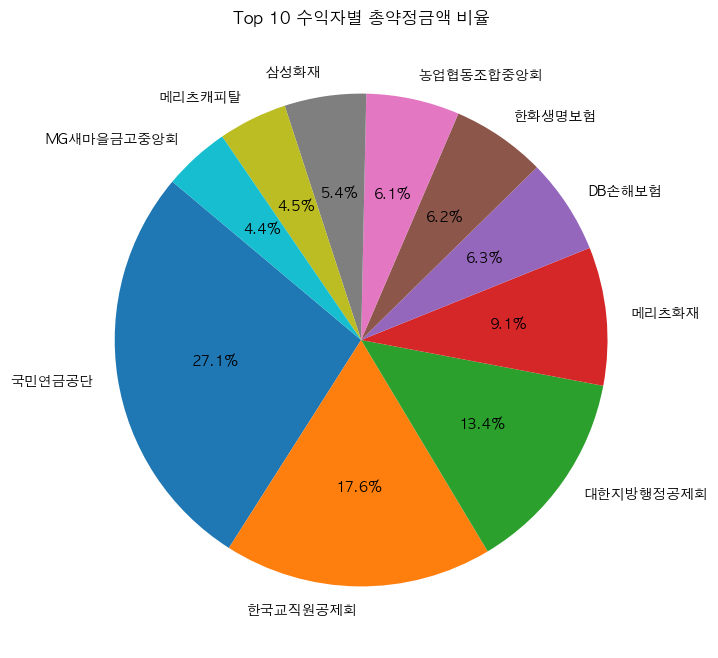

In [27]:
top10_beneficiaries = top10_beneficiaries.sort_values(by='총약정금액_원화', ascending=False)
plt.figure(figsize=(8, 8))
plt.pie(top10_beneficiaries['총약정금액_원화'], labels=top10_beneficiaries['수익자'], autopct='%1.1f%%', startangle=140)
plt.title('Top 10 수익자별 총약정금액 비율')
plt.show()

1.1. 수익자 Top 10: 당사 운용/청산 자산 통틀어, 수익자로서 총약정금액 기준으로 가장 높은 투자를 한 곳은 국민연금공단, 한국교직원공제회 순으로 랭크되었다. 화재보험사중에서는 메리츠화재가 수익자로서 가장 많은 금액 투자 약정을 하였다.

In [28]:
sum_by_class = ibene_view_.groupby('수익자분류')['총약정금액_원화'].sum().reset_index()
sum_by_beneficiary = ibene_view_.groupby(['수익자분류'])['총약정금액_원화'].sum().reset_index()
sum_by_beneficiary.sort_values(by='총약정금액_원화', ascending=False).head(10).style.format({'총약정금액_원화': "{:,.0f}"})

,수익자분류,총약정금액_원화
6,연기금,"7,335,679,245,100"
5,보험사,"6,349,049,790,496"
11,조합,"1,516,356,477,111"
13,증권사,"1,511,895,462,099"
8,일반기업,"1,332,659,090,106"
14,펀드,"1,051,971,960,418"
4,리스사,"933,742,675,997"
0,SPC,"921,301,077,055"
7,은행,"880,992,803,667"
10,정부기관,"732,197,844,949"


1.2. 수익자분류: 연기금은 총 7.3조, 보험사는 6.3조 순으로 당사가 운영/청산한 펀드에 수익자로서 투자 약정하였다

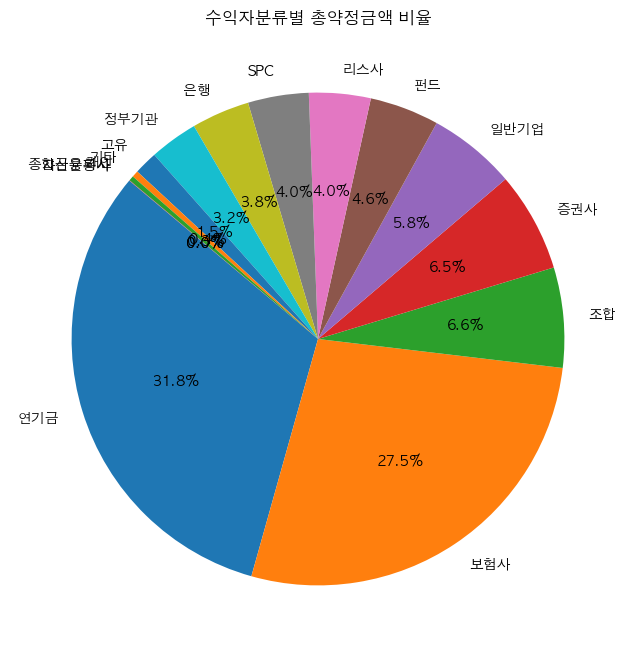

In [29]:
sum_by_beneficiary = sum_by_beneficiary.sort_values(by='총약정금액_원화', ascending=False)
plt.figure(figsize=(8, 8))
plt.pie(sum_by_beneficiary['총약정금액_원화'], labels=sum_by_beneficiary['수익자분류'], autopct='%1.1f%%', startangle=140)
plt.title('수익자분류별 총약정금액 비율')
plt.show()

In [30]:
a = sum_by_beneficiary[sum_by_beneficiary['수익자분류'].isin(['연기금', '보험사'])]['총약정금액_원화'].sum()
b = ibene_view_['총약정금액_원화'].sum()
print(f"연기금/보험사 약정금액(a): {a:,.0f}\n전체 약정금액(b): {b:,.0f}\na/b*100: {a/b*100:.2f}%")

연기금/보험사 약정금액(a): 13,684,729,035,596
전체 약정금액(b): 32,000,341,538,928
a/b*100: 42.76%


1.2. 수익자분류: 당사 운용/청산 자산 통틀어, 수익자분류로로서 총약정금액 기준으로 가장 높은 투자를 한 곳은 연기금 -> 보험사 -> 조합순이다. 또한 탑2분류인 `연기금, 보험사가 수익자로서 약정한 금액이 당사 역사적 전체 약정금 중 42.7%에 육박`한다.

### EDA 2. 개별 기관 탐색

In [31]:
ibene_view_['연도'] = pd.to_datetime(ibene_view_['펀드설정일']).dt.year
annual_sum_nps = ibene_view_[ibene_view_['수익자'] == '국민연금공단'].groupby('연도')['총약정금액_원화'].sum().reset_index()
annual_sum_nps.style.format({'총약정금액_원화': "{:,.0f}"})

,연도,총약정금액_원화
0,2012,"264,100,000,000"
1,2014,"110,000,000,000"
2,2016,"527,350,000,000"
3,2017,"340,000,000,000"
4,2018,"397,500,000,000"
5,2020,"250,000,000,000"
6,2021,"800,000,000,000"


2.1. Deep dive to NPS: 국민연금공단의 약정금액 추이 내역이며, 2016~2021 5개년(2019 제외)동안 연간 평균 4000억이상의 투자를 단행하였다

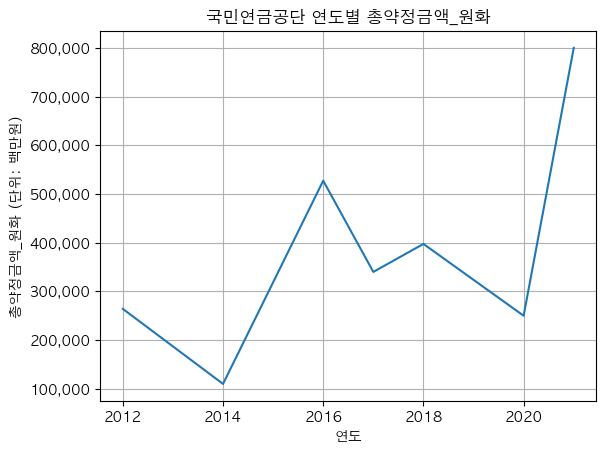

In [32]:

fig, ax = plt.subplots()

ax.plot(annual_sum_nps['연도'], annual_sum_nps['총약정금액_원화'])


ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/1000000):,}'))


ax.set_title('국민연금공단 연도별 총약정금액_원화')
ax.set_xlabel('연도')
ax.set_ylabel('총약정금액_원화 (단위: 백만원)')
plt.grid()
plt.show()

2.1. Deep dive to NPS: 국민연금공단의 약정금액 추이 내역이며, 2016~2021 5개년(2019 제외)동안 연간 평균 4000억이상의 투자를 단행하였다

In [33]:
ibene_view_['연도'] = pd.to_datetime(ibene_view_['펀드설정일']).dt.year
annual_sum_thek = ibene_view_[ibene_view_['수익자'] == '한국교직원공제회'].groupby('연도')['총약정금액_원화'].sum().reset_index()
annual_sum_thek.style.format({'총약정금액_원화': "{:,.0f}"})

,연도,총약정금액_원화
0,2014,"66,250,000,000"
1,2015,"82,590,000,000"
2,2017,"96,355,000,000"
3,2018,"281,861,333,908"
4,2019,"206,276,900,000"
5,2020,"337,275,080,340"
6,2021,"150,000,000,000"
7,2022,"526,093,503,670"


In [34]:
annual_sum_thek.총약정금액_원화.mean()/1e8 #억

2183.3772723975

2.2. Deep dive to 한국교직원공제회: 한국교직원공제회 약정금액 추이 내역이며, 2017~2022 매해 빠짐없이 투자를 하였다. 투자금은 평균 연간 2100억원 수준이었다

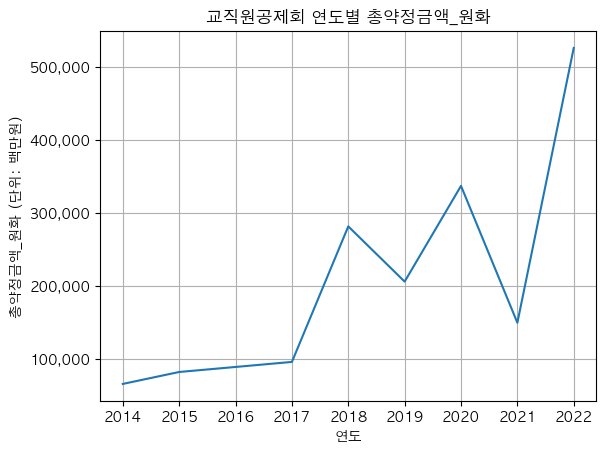

In [35]:

fig, ax = plt.subplots()

ax.plot(annual_sum_thek['연도'], annual_sum_thek['총약정금액_원화'])


ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/1000000):,}'))


ax.set_title('교직원공제회 연도별 총약정금액_원화')
ax.set_xlabel('연도')
ax.set_ylabel('총약정금액_원화 (단위: 백만원)')
plt.grid()
plt.show()

2.2. Deep dive to 한국교직원공제회: Timeseries Plot

## 3. Fundaum(펀드AUM정보) EDA
- ifundaum_aureum 사용: 주요 cols -> "약칭", "자산수", "설정일", "자산명", "국내/해외", "펀드구분", "투자전략", "투자자산유형" '약정_Loan 총액(원)' '약정_Equity 총액(원)' '약정_기준일자 임대보증금(원)' '약정_AUM(원)'

### EDA 1. 전체 설정 펀드개수 / 연도별 탐색

In [36]:
ifundaum_aureum_ = ifundaum_aureum.copy()
# 약간의 전처리.. 마지막 행은 합을 나타내는 행 -> deduct
ifundaum_aureum_ = ifundaum_aureum_.iloc[:-1, :]
# 연도 정보 추가
ifundaum_aureum_['연도'] = ifundaum_aureum_['설정일'].str[:4]
# 데이터 변환..
int_cols = ['약정_Loan 총액(원)', '약정_Equity 총액(원)', '약정_기준일자 임대보증금(원)', '약정_AUM(원)']
# 약정금 정보 없는 행 제거
ifundaum_aureum_ = ifundaum_aureum_.dropna(subset=int_cols)
ifundaum_aureum_[int_cols] = ifundaum_aureum_[int_cols].astype(int)


view_cols = [
"약칭", "자산수", "설정일", "자산명", "국내/해외", "펀드구분", "투자전략", "투자자산유형",
'약정_Loan 총액(원)', '약정_Equity 총액(원)', '약정_기준일자 임대보증금(원)', '약정_AUM(원)'
]

In [37]:

total_funds = len(ifundaum_aureum_)
total_funds_aum_sum = ifundaum_aureum_['약정_AUM(원)'].sum()

funds_by_year = ifundaum_aureum_.groupby('연도').agg(
    설정펀드갯수=('연도', 'size'),
    연도별설정액=('약정_AUM(원)', 'sum')
).reset_index()
funds_by_year['당해개수/전체개수(%)'] = funds_by_year['설정펀드갯수'] / total_funds * 100
funds_by_year['당해설정액/전체설정액(%)'] = funds_by_year['연도별설정액'] / total_funds_aum_sum * 100
print(f"전체 설정 펀드개수: {total_funds}건")
funds_by_year.style.format({'연도별설정액': "{:,.0f}"})

전체 설정 펀드개수: 345건


,연도,설정펀드갯수,연도별설정액,당해개수/전체개수(%),당해설정액/전체설정액(%)
0,2011,1,"466,632,173,733",0.289855,0.697824
1,2012,6,"2,431,714,461,369",1.739130,3.636500
2,2013,5,"1,072,525,605,429",1.449275,1.603905
3,2014,10,"1,999,339,099,463",2.898551,2.989906
4,2015,8,"1,850,649,670,160",2.318841,2.767549
5,2016,16,"4,172,700,516,283",4.637681,6.240053
6,2017,25,"4,730,556,605,744",7.246377,7.074297
7,2018,24,"5,169,081,463,556",6.956522,7.730088
8,2019,34,"9,757,441,400,617",9.855072,14.591738
9,2020,48,"10,954,490,350,019",13.913043,16.381862


1.1. 당사 역사적 펀드개수는 343건이다. 2017년 20개를 넘은 이후로 2023년까지 매해 30~60개의 펀드가 설정되고 있다. 설정액 기준으로 2021년이 12조원으로 개수로보나 약정AUM으로 보나 최고치를 기록하였다

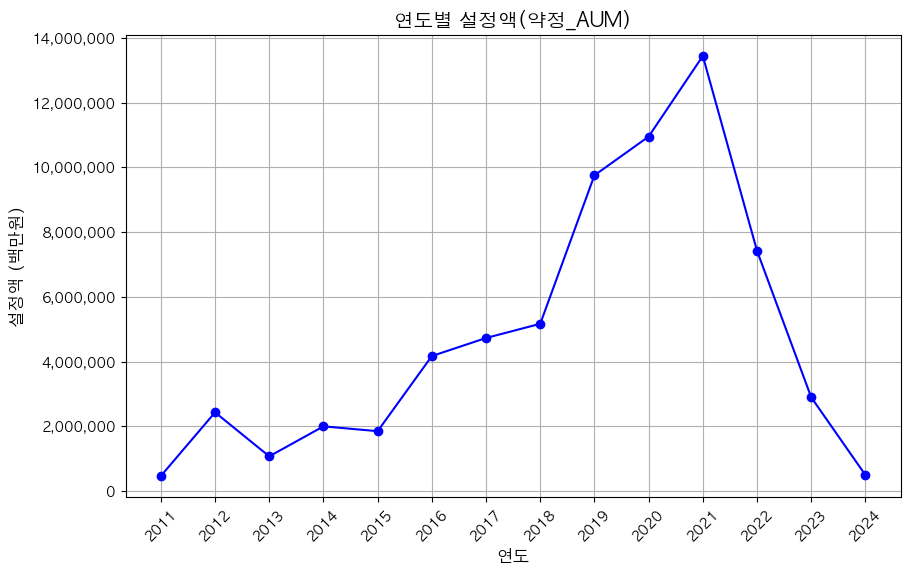

In [38]:

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(funds_by_year['연도'], funds_by_year['연도별설정액'], marker='o', linestyle='-', color='b')


ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x/1000000):,}'))


ax.set_title('연도별 설정액(약정_AUM)', fontsize=14)
ax.set_xlabel('연도', fontsize=12)
ax.set_ylabel('설정액 (백만원)', fontsize=12)

plt.xticks(rotation=45)
plt.grid(True)
plt.show()

1.1. 연도별 설정액 추이 Plot

### EDA 2. 자산유형별 펀드개수, 설정금액, Top N

In [39]:
asset_type_analysis = ifundaum_aureum_.groupby('투자자산유형').agg(
    설정개수=('투자자산유형', 'size'),
    설정액=('약정_AUM(원)', 'sum')
).reset_index()


print("자산유형별 설정개수 및 설정 금액:")
asset_type_analysis.sort_values(by='설정액', ascending=False).style.format({'설정액': "{:,.0f}"})


자산유형별 설정개수 및 설정 금액:


,투자자산유형,설정개수,설정액
7,복합(오피스),44,"19,934,986,582,594"
10,오피스,57,"14,207,045,792,736"
11,주거,41,"7,859,098,515,303"
5,물류,35,"6,271,770,259,590"
4,리테일,19,"4,164,086,439,925"
13,특별자산,27,"2,275,559,738,800"
12,지분증권,28,"2,210,572,669,609"
3,데이터센터,7,"1,979,914,838,615"
1,기타,42,"1,879,540,647,119"
9,복합(호텔),6,"1,628,709,049,692"


2.1. 자산유형별 현황: 역사적으로 갯수, 설정액으로 보아 오피스, 복합(오피스)가 가장 높은 설정액을 보였다. 가장 적은 유형으로는 NPL이며 총 4개, 설정액은 약 2816억이다.

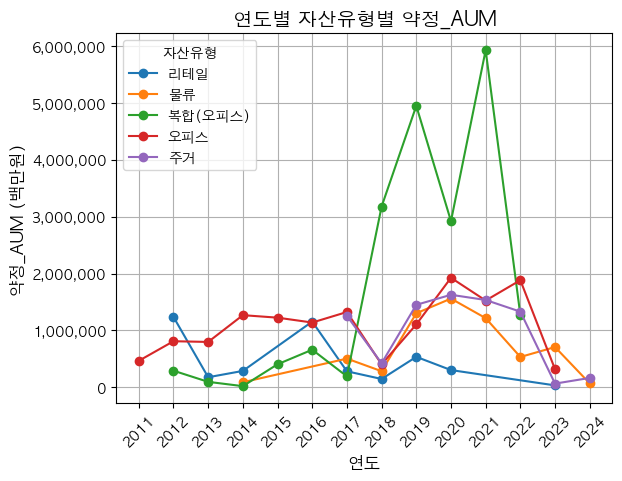

In [40]:

top_5_asset_types = asset_type_analysis.nlargest(5, '설정액')['투자자산유형']


filtered_data = ifundaum_aureum_.loc[ifundaum_aureum_['투자자산유형'].isin(top_5_asset_types)]
filtered_data['연도'] = pd.to_numeric(filtered_data['연도'], errors='coerce')
filtered_data = filtered_data.sort_values('연도')


grouped_data = filtered_data.groupby(['연도', '투자자산유형'])['약정_AUM(원)'].sum().reset_index()


grouped_data['연도'] = pd.to_numeric(grouped_data['연도'], errors='coerce')
grouped_data = grouped_data.sort_values(['연도', '투자자산유형'])


grouped_by_asset_type = grouped_data.groupby('투자자산유형')

fig, ax = plt.subplots()


for asset_type, group in grouped_by_asset_type:
    ax.plot(group['연도'], group['약정_AUM(원)'], marker='o', label=asset_type)


ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x/1e6):,}'))


ax.set_title('연도별 자산유형별 약정_AUM', fontsize=14)
ax.set_xlabel('연도', fontsize=12)
ax.set_ylabel('약정_AUM (백만원)', fontsize=12)


ax.set_xticks(np.arange(2011, 2025))
ax.set_xticklabels(np.arange(2011, 2025), rotation=45)


ax.legend(title='자산유형')
plt.grid(True)

plt.show()

2.2. 상위 5개 자산유형별 연도별 현황 plot: 2.1에서 언급했듯, 오피스가 매해 설정액, 설정개수 차원에서 가장 두드러짐을 확인할 수 있다. 2018년도의 경우 Top 5자산군 모두 설정액이 줄어든 해였는데, 복합(오피스) 유형의 설정액이 특히 컸다. 물류의 경우 2014년도 첫 설정이래 2019년도부터 설정이 활발하게 되고 있으며 특히 2023년도에는 상위 5개 자산유형중 가장 높은 설정액을 달성하였다

### EDA 3. 국내해외별 펀드개수, 설정금액, Top N

In [41]:
asset_type_analysis = ifundaum_aureum_.groupby('국내/해외').agg(
    설정개수=('국내/해외', 'size'),
    설정액=('약정_AUM(원)', 'sum')
).reset_index()


print("국내/해외별 설정개수 및 설정 금액:")
asset_type_analysis.sort_values(by='설정액', ascending=False).style.format({'설정액': "{:,.0f}"})


국내/해외별 설정개수 및 설정 금액:


,국내/해외,설정개수,설정액
0,국내,202,"48,635,671,966,976"
1,해외,138,"17,933,351,917,643"
2,혼합,5,"300,607,101,576"


In [42]:
ifundaum_aureum_[ifundaum_aureum_['국내/해외'] == '혼합'][['약칭', '자산명', '약정_AUM(원)']]

,약칭,자산명,약정_AUM(원)
191,리츠포트폴리오 2호,Global REITs/국내 REITs,205000000000
212,투자풀11호,Global REITs(미래OCIO),6104893817
231,연기금글로벌리츠1호,Global REITs(삼성OCIO),25215846714
303,올인원K리츠,NaN,52580954024
345,R데이터센터,"북미DC포트폴리오, 분당Hostway IDC",11705407021


3.1. 국내해외별 분석: 당사 345개 펀드중 국내 펀드 설정액이 48조로 가장 컸으며, 해외 펀드의 경우 138개 약 18조로 뒤를 잇는다. 
혼합의 경우 주로 REITs형태(국내해외 자산 포트폴리오 구성 or OCIO)이거나 국내/해외 데이터센터가 자산일 경우 분류되며 전체 5개로 비중은 적다

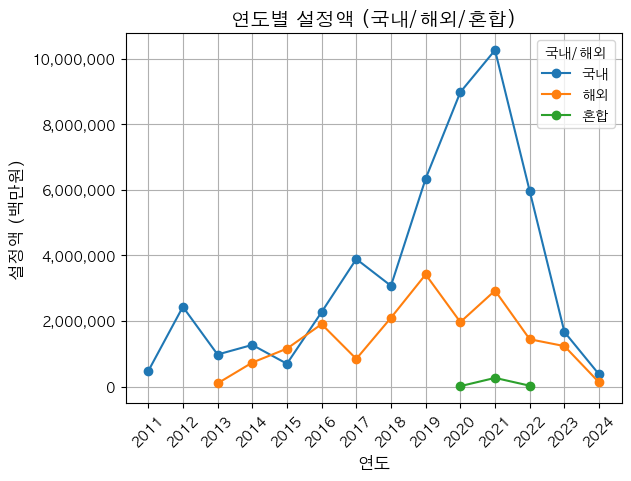

In [43]:

grouped_data = ifundaum_aureum_.groupby(['연도', '국내/해외'])['약정_AUM(원)'].sum().reset_index()


grouped_data['연도'] = pd.to_numeric(grouped_data['연도'], errors='coerce')
grouped_data = grouped_data.sort_values(['연도', '국내/해외'])


grouped_by_type = grouped_data.groupby('국내/해외')

fig, ax = plt.subplots()


for data_type, group in grouped_by_type:
    ax.plot(group['연도'], group['약정_AUM(원)'], marker='o', label=data_type)


ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x/1e6):,}'))


ax.set_title('연도별 설정액 (국내/해외/혼합)', fontsize=14)
ax.set_xlabel('연도', fontsize=12)
ax.set_ylabel('설정액 (백만원)', fontsize=12)

ax.set_xticks(np.arange(2011, 2025))
ax.set_xticklabels(np.arange(2011, 2025), rotation=45)


ax.legend(title='국내/해외')
plt.grid(True)

plt.show()

3.2. 국내해외별 연도별 분석 plot

## 4. Lend(대주정보) EDA
- ilend_view 사용: "펀드코드","자산명","대주코드", "대주명", "대출실행일", 
"대출약정금액(원)", "대출금리", "대출유형", "이자유형", "투자자산유형"

In [44]:
ilend_view_ = ilend_view.copy()
view_cols = ["펀드코드","자산명","대주코드", "대주명", "대출실행일", 
"대출약정금액(원)", "대출금리", "대출유형", "이자유형", "투자자산유형"]
# 전처리. 
# 주요열에 결측이 있을 경우 deduct
original_length = ilend_view_.shape[0]
# 결측값이 있는 행 제거
ilend_view_ = ilend_view_.dropna(subset=view_cols)
ilend_view_["대출약정금액(원)"] = ilend_view_["대출약정금액(원)"].astype(int)
# 대출약정금액(원) 0원 제거
ilend_view_ = ilend_view_[ilend_view_['대출약정금액(원)'] > 0]

# '대출실행일' 열이 '2099-'로 시작하는 행 제거
ilend_view_ = ilend_view_[~ilend_view_['대출실행일'].str.startswith('2099-')]

### EDA 1. 당사 펀드 대출약정액 현황 - 전체

In [45]:
# 연도 추출
ilend_view_['연도'] = pd.to_datetime(ilend_view_['대출실행일']).dt.year


annual_totals = ilend_view_.groupby('연도')['대출약정금액(원)'].sum()

grouped_data = ilend_view_.groupby(['연도', '투자자산유형'])['대출약정금액(원)'].sum().reset_index()

# 결과를 저장할 리스트
results = []

# 연도별 처리
for year in annual_totals.index:

    year_data = grouped_data[grouped_data['연도'] == year]
    

    total_amount = annual_totals[year]
    

    max_type_data = year_data.loc[year_data['대출약정금액(원)'].idxmax()]
    max_type = max_type_data['투자자산유형']
    max_amount = max_type_data['대출약정금액(원)']
    
    # 제일 큰 투자자산유형 대출약정금액 비율 계산
    max_amount_ratio = (max_amount / total_amount) * 100
    
    # 결과 리스트에 추가
    results.append([year, total_amount, max_type, max_amount_ratio])

# 결과를 데이터프레임으로 변환
results_df = pd.DataFrame(results, columns=['연도', '대출약정금액(원)합계', 'Top 1 투자자산유형', '대출약정금액 비율'])


In [46]:
results_df.style.format({'대출약정금액(원)합계': "{:,.0f}"})

,연도,대출약정금액(원)합계,Top 1 투자자산유형,대출약정금액 비율
0,2013,"123,200,000,000",리테일,73.051948
1,2014,"184,000,000,000",오피스,100.000000
2,2015,"213,700,000,000",오피스,71.689284
3,2016,"114,919,129,010",오피스,73.616987
4,2017,"542,650,055,946",오피스,77.895505
5,2018,"111,000,000,000",호텔,81.981982
6,2019,"628,043,554,626",복합(오피스),67.240559
7,2020,"3,605,535,797,234",오피스,36.230399
8,2021,"5,315,373,170,807",복합(오피스),66.207957
9,2022,"6,628,840,466,728",복합(오피스),22.477536


### EDA 2. 당사 펀드 대출약정액 현황 - 대출유형별, 투자자산유형별

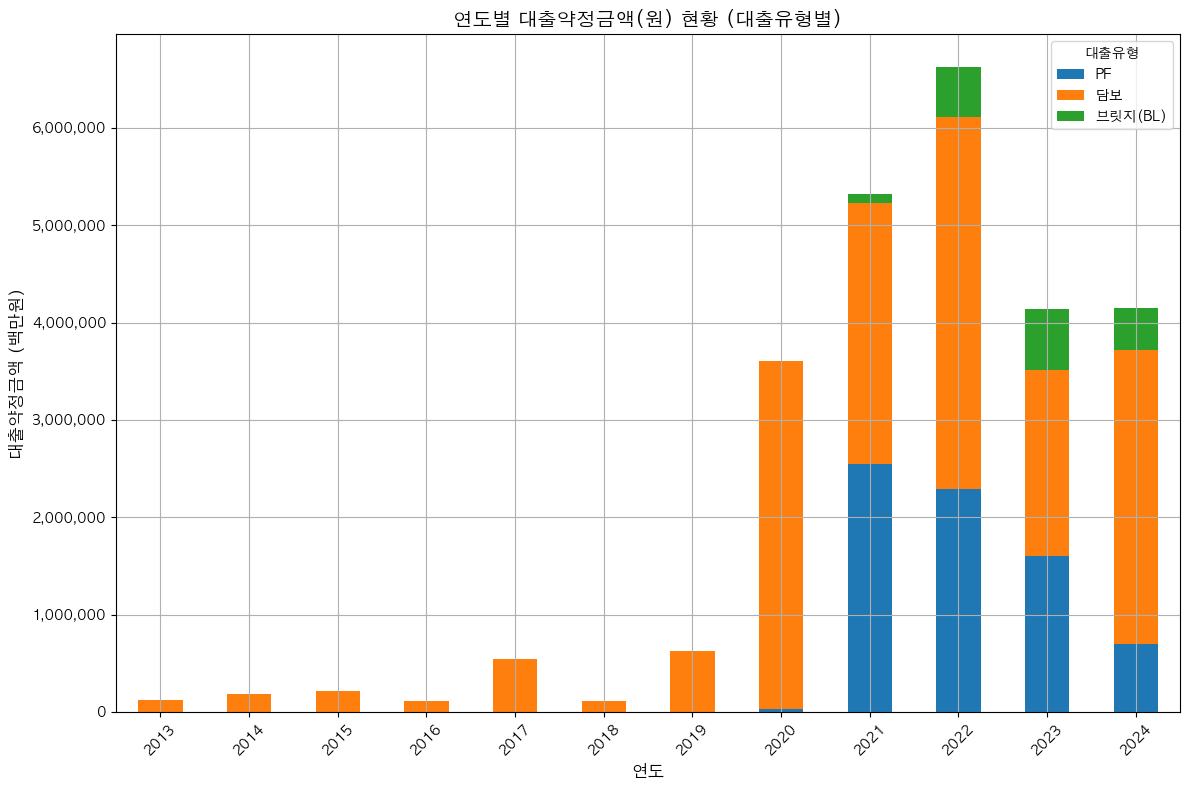

In [47]:

grouped_data = ilend_view_.groupby(['연도', '대출유형'])['대출약정금액(원)'].sum().unstack()


ax = grouped_data.plot(kind='bar', stacked=True, figsize=(12, 8))


ax.set_title('연도별 대출약정금액(원) 현황 (대출유형별)', fontsize=14)
ax.set_xlabel('연도', fontsize=12)
ax.set_ylabel('대출약정금액 (백만원)', fontsize=12)


ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x/1e6):,}'))


ax.legend(title='대출유형')
plt.grid(True)

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

1.1 연도별 대출유형별 약정금액 현황

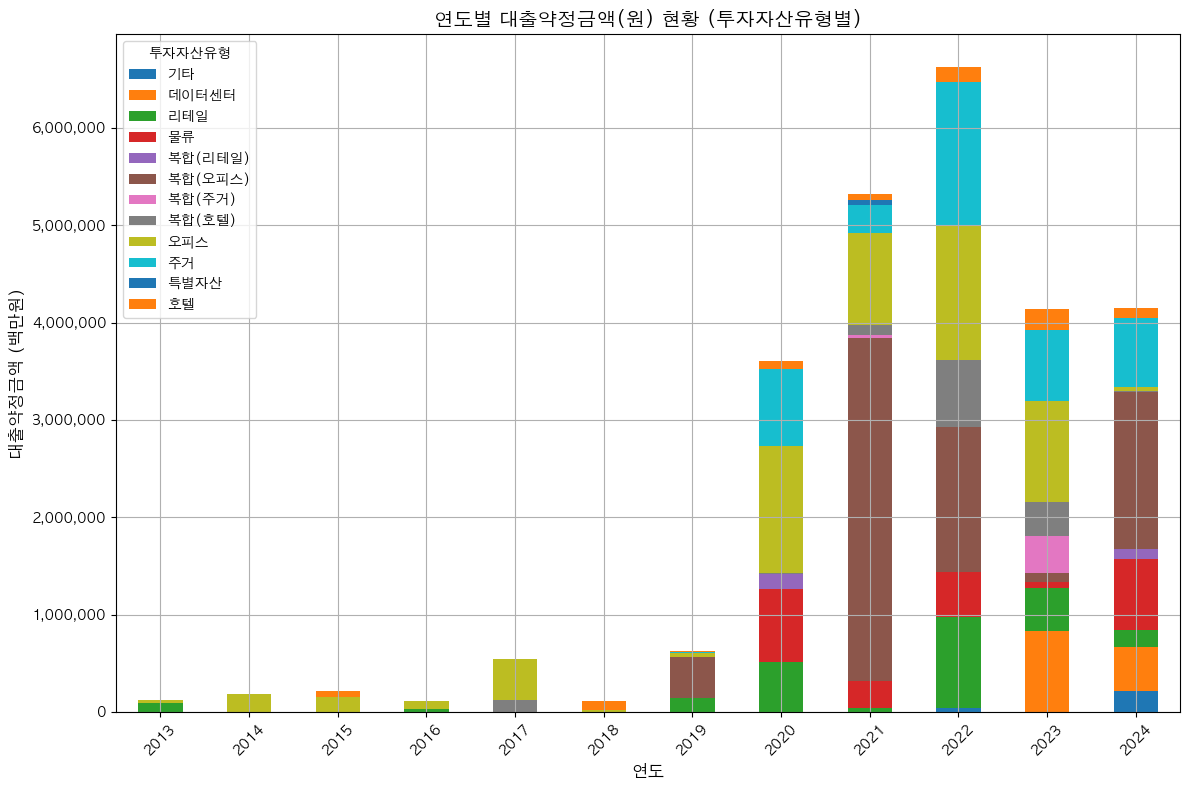

In [48]:

grouped_data = ilend_view_.groupby(['연도', '투자자산유형'])['대출약정금액(원)'].sum().unstack()


ax = grouped_data.plot(kind='bar', stacked=True, figsize=(12, 8))


ax.set_title('연도별 대출약정금액(원) 현황 (투자자산유형별)', fontsize=14)
ax.set_xlabel('연도', fontsize=12)
ax.set_ylabel('대출약정금액 (백만원)', fontsize=12)

#
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x/1e6):,}'))


ax.legend(title='투자자산유형')
plt.grid(True)

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

### EDA 2. 당사 펀드 대출금리 현황

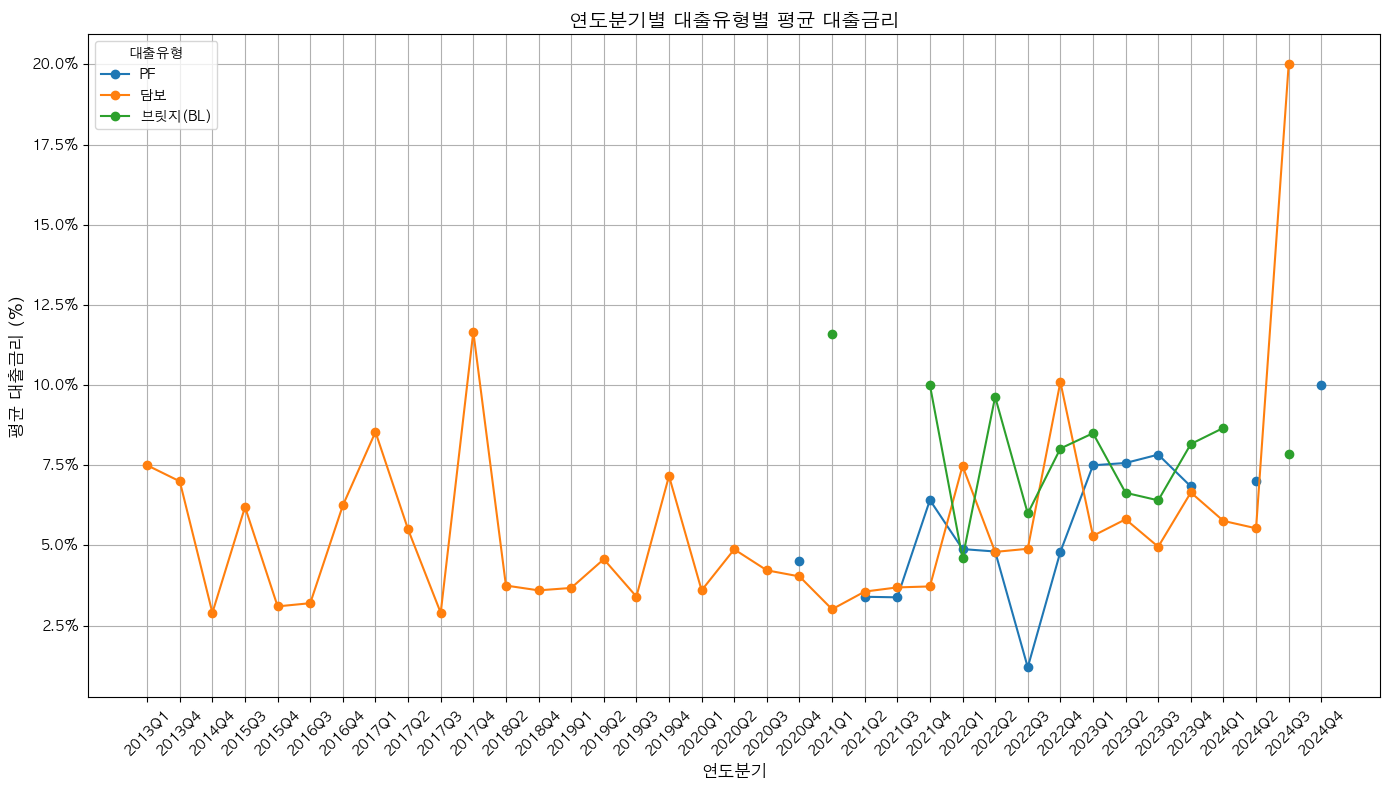

In [49]:

ilend_view_['연도분기'] = pd.to_datetime(ilend_view_['대출실행일']).dt.to_period('Q').astype(str)


grouped_data = ilend_view_.groupby(['연도분기', '대출유형'])['대출금리'].mean().unstack()


ax = grouped_data.plot(kind='line', marker='o', figsize=(14, 8))


ax.set_title('연도분기별 대출유형별 평균 대출금리', fontsize=14)
ax.set_xlabel('연도분기', fontsize=12)
ax.set_ylabel('평균 대출금리 (%)', fontsize=12)


ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}%'))


ax.legend(title='대출유형')
plt.grid(True)


plt.xticks(rotation=45)


plt.tight_layout()
plt.xticks(ticks=range(len(grouped_data.index)), labels=grouped_data.index, rotation=45)


plt.show()

In [50]:
ilend_view_[ilend_view_['연도분기'] == '2024Q3'][view_cols]

,펀드코드,자산명,대주코드,대주명,대출실행일,대출약정금액(원),대출금리,대출유형,이자유형,투자자산유형
52,112033,대구시티센터,A60017,IOIV,2024-07-30,2916925363,20.00,담보,고정금리,복합(호텔)
459,P00006,세운5구역 개발사업,A60351,"iM캐피탈(구, DGB캐피탈)",2024-07-05,5000000000,7.80,브릿지(BL),고정금리,주거
460,P00006,세운5구역 개발사업,A60053,NH농협은행,2024-07-05,10000000000,7.80,브릿지(BL),고정금리,주거
461,P00006,세운5구역 개발사업,A60669,농축협대주단,2024-07-05,219900000000,6.70,브릿지(BL),고정금리,주거
462,P00006,세운5구역 개발사업,A60054,농협중앙회,2024-07-05,20000000000,7.80,브릿지(BL),고정금리,주거
463,P00006,세운5구역 개발사업,A60096,신한캐피탈,2024-07-05,15000000000,7.80,브릿지(BL),고정금리,주거
464,P00006,세운5구역 개발사업,A60092,신한투자증권,2024-07-05,100000000,6.70,브릿지(BL),고정금리,주거
465,P00006,세운5구역 개발사업,A60092,신한투자증권,2024-07-05,10000000000,9.00,브릿지(BL),고정금리,주거
466,P00006,세운5구역 개발사업,A60671,에이에이엠제일차,2024-07-05,24500000000,7.80,브릿지(BL),고정금리,주거
467,P00006,세운5구역 개발사업,A60105,우리은행,2024-07-05,15500000000,7.80,브릿지(BL),고정금리,주거


2.1. 연도별 분기별 대출유형별 금리는 위 Plot과 같다. 일부시기(2022Q3)제외하고 담보대출의 평균금리가 PF, 브릿지 대출의 금리보다 낮은 편이다. 2024년도 3Q에 담보대출은 대구시티센터 자산에 관한 20% 대출 1건이 있다.

### EDA 3. 대주현황

In [51]:
# 전처리. 대주명=미정인 경우가 있으므로 삭제
ilend_view_ = ilend_view_[ilend_view_['대주명'] != '미정']

# 대출유형별로 대출약정금액(원) 집계
lender_type_sums = ilend_view_.groupby(['대주명', '대출유형'])['대출약정금액(원)'].sum().unstack(fill_value=0)

top_lenders = lender_type_sums.sum(axis=1)
top_10_lenders = top_lenders.nlargest(10)

top_10_lenders_df = lender_type_sums.loc[top_10_lenders.index]

top_10_lenders_df['총대출약정금액(원)'] = top_10_lenders_df.sum(axis=1)


top_10_lenders_df = top_10_lenders_df.reset_index()
top_10_lenders_df.columns = ['대주명', '담보대출약정금액', 'PF대출약정금액', '브릿지(BL)대출약정금액', '총대출약정금액(원)']
top_10_lenders_df['총대출약정금액(원)'] = top_10_lenders_df['총대출약정금액(원)'].apply(lambda x: f"{x:,.0f}")
top_10_lenders_df['담보대출약정금액'] = top_10_lenders_df['담보대출약정금액'].apply(lambda x: f"{x:,.0f}")
top_10_lenders_df['PF대출약정금액'] = top_10_lenders_df['PF대출약정금액'].apply(lambda x: f"{x:,.0f}")
top_10_lenders_df['브릿지(BL)대출약정금액'] = top_10_lenders_df['브릿지(BL)대출약정금액'].apply(lambda x: f"{x:,.0f}")
top_10_lenders_df

,대주명,담보대출약정금액,PF대출약정금액,브릿지(BL)대출약정금액,총대출약정금액(원)
0,신한은행,"380,900,000,000","1,677,835,400,000",0,"2,058,735,400,000"
1,삼성생명,0,"1,703,875,757,576",0,"1,703,875,757,576"
2,삼성화재,"295,000,000,000","810,600,000,000",0,"1,105,600,000,000"
3,KB국민은행,"259,903,000,000","720,996,000,000",0,"980,899,000,000"
4,KDB산업은행,"294,700,000,000","630,300,000,000",0,"925,000,000,000"
5,IBK기업은행,"360,000,000,000","547,050,000,000",0,"907,050,000,000"
6,우리은행,"10,000,000,000","831,892,600,000","15,500,000,000","857,392,600,000"
7,MG새마을금고중앙회,"250,000,000,000","574,424,242,424",0,"824,424,242,424"
8,현대해상화재보험,"150,000,000,000","653,600,000,000",0,"803,600,000,000"
9,DB손해보험,"245,000,000,000","457,600,000,000",0,"702,600,000,000"


3.1. 대주별 대출유형별 대출약정금액(Top10): 신한은행이 총 2조원, 삼성생명 1.7조, 삼성화재 1.1조 순으로 당사와 대출약정을 체결하였다. 대출약정금합 기준 Top10 대주중 유일하게 우리은행이 브릿지대출 155억 대출약정을 당사와 체결하였다

## 4. RSQ 데이터

In [52]:
market_market_ = market_market.copy()
market_market_['price'] = market_market_['price']*1000
market_market_ = market_market_.dropna(subset=['price', 'pnu', 'contract_date'])

In [53]:
cbd = ['11110', '11140']
gbd = ['11680', '11650']
ybd = ['1156011000']
bbd = ['41135']

def assign_district(pnu):
    if any(pnu.startswith(prefix) for prefix in cbd):
        return 'cbd'
    elif any(pnu.startswith(prefix) for prefix in gbd):
        return 'gbd'
    elif any(pnu.startswith(prefix) for prefix in ybd):
        return 'ybd'
    elif any(pnu.startswith(prefix) for prefix in bbd):
        return 'bbd'
    else:
        return 'nonbd'

market_market_['district'] = market_market_['pnu'].apply(assign_district)

### EDA1. 상업용 부동산 실거래 

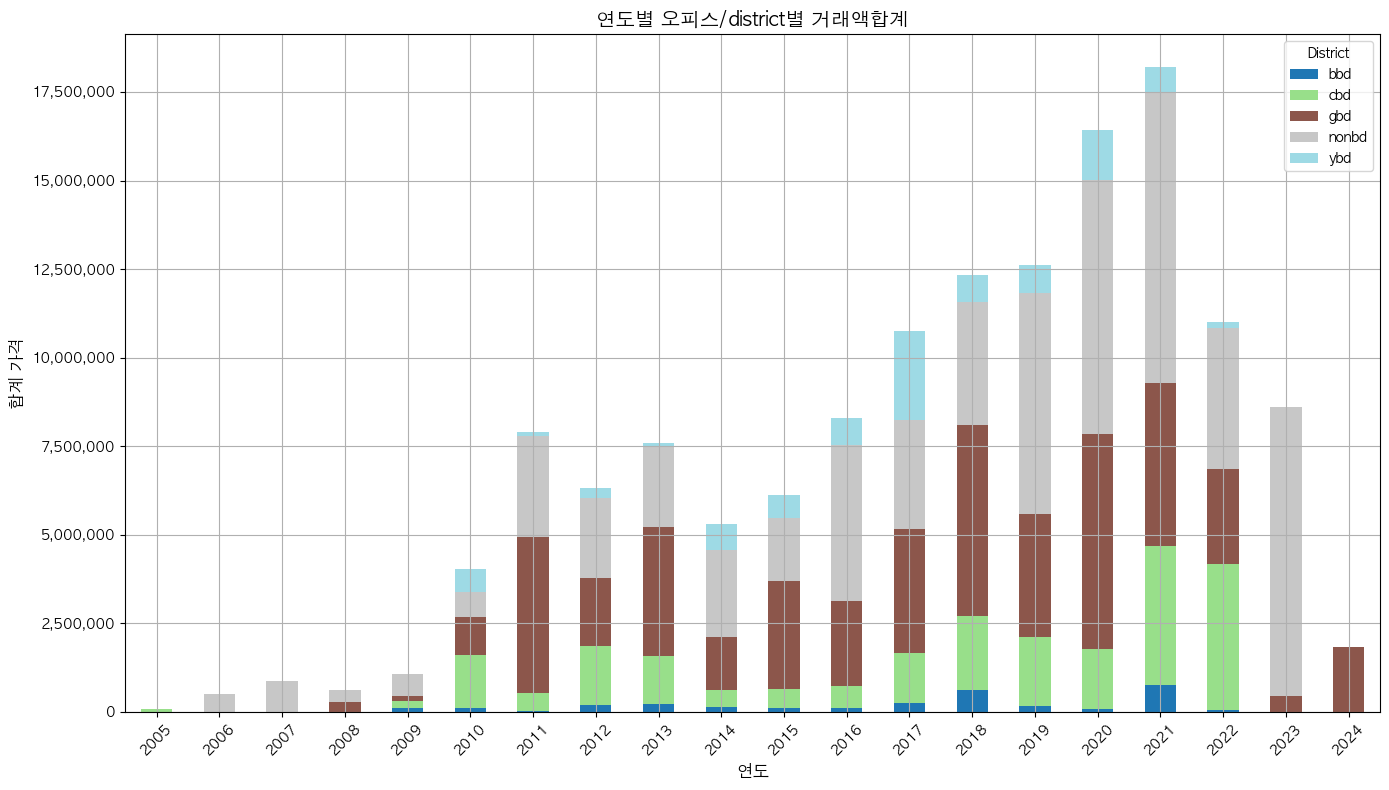

In [54]:
# 1. 'class' 값이 '오피스'인 행 필터링
office_data = market_market_[market_market_['class'] == '오피스']

# 2. 'contract_date'에서 연도 추출
office_data['year'] = pd.to_datetime(office_data['contract_date'], format='%Y%m%d').dt.year
office_data['year'] = office_data['year'].astype(int)
# 3. 연도별 'district'별 'price'의 합계 계산
grouped_data = office_data.groupby(['year', 'district'])['price'].sum().unstack()

# 4. 스택형 바 차트 생성
ax = grouped_data.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='tab20')

# 그래프 제목 및 축 라벨 설정
ax.set_title('연도별 오피스/district별 거래액합계', fontsize=14)
ax.set_xlabel('연도', fontsize=12)
ax.set_ylabel('합계 가격', fontsize=12)

# y축에 1,000단위 콤마 표시 적용
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x/1e6):,}'))

# 레전드 및 그리드 추가
ax.legend(title='District')
plt.grid(True)

# x축 레이블 회전
plt.xticks(rotation=45)

# 레이아웃 조정
plt.tight_layout()

# 그래프 출력
plt.show()

4.1.연도별 오피스 거래액 plot: 연도별로 오피스거래액은 2014년 이래 지속적으로 상승추세를 보이며 2021년에 18조원을 초과하였으나 2022년 부터 11조원대로 하락하였다. 2019~2021 기간동안 nonbd(서울3대권역/BBD가 아닌곳)의 거래가 많았던 것이 눈에 띈다. 

In [55]:

grouped_data['총거래금액'] = grouped_data.sum(axis=1)


for district in ['cbd', 'gbd', 'ybd', 'bbd', 'nonbd']:
    if district in grouped_data.columns:
        grouped_data[district + '_비율'] = grouped_data[district] / grouped_data['총거래금액']
    else:
        grouped_data[district + '_비율'] = 0


grouped_data = grouped_data.fillna(0)
grouped_data['총거래금액'] = grouped_data['총거래금액'].apply(lambda x: f"{int(x):,}")
for district in ['cbd', 'gbd', 'ybd', 'bbd', 'nonbd']:
    grouped_data[district] = grouped_data[district].apply(lambda x: f"{int(x):,}")
    grouped_data[district + '_비율'] = grouped_data[district + '_비율'].apply(lambda x: f"{x*100:.2f}%")


result = grouped_data.reset_index()


result = result[['year', '총거래금액', 'cbd', 'gbd', 'ybd', 'bbd', 'nonbd'] + [col for col in result.columns if '_비율' in col]]
result

district,year,총거래금액,cbd,gbd,ybd,bbd,nonbd,cbd_비율,gbd_비율,ybd_비율,bbd_비율,nonbd_비율
0,2005,"91,000,000,000","91,000,000,000",0,0,0,0,100.00%,0.00%,0.00%,0.00%,0.00%
1,2006,"495,800,000,000",0,0,0,0,"495,800,000,000",0.00%,0.00%,0.00%,0.00%,100.00%
2,2007,"879,965,000,000",0,0,0,0,"879,965,000,000",0.00%,0.00%,0.00%,0.00%,100.00%
3,2008,"622,187,897,900",0,"288,777,039,800",0,0,"333,410,858,100",0.00%,46.41%,0.00%,0.00%,53.59%
4,2009,"1,061,735,800,000","201,290,000,000","163,782,500,000",0,"97,973,300,000","598,690,000,000",18.96%,15.43%,0.00%,9.23%,56.39%
5,2010,"4,022,246,103,229","1,479,600,600,000","1,078,593,870,000","648,404,283,200","122,995,000,000","692,652,350,029",36.79%,26.82%,16.12%,3.06%,17.22%
6,2011,"7,908,515,205,780","529,231,671,830","4,386,609,796,850","129,000,000,000","15,170,000,000","2,848,503,737,100",6.69%,55.47%,1.63%,0.19%,36.02%
7,2012,"6,327,973,724,500","1,663,412,906,100","1,918,860,746,460","285,159,996,180","209,000,000,000","2,251,540,075,760",26.29%,30.32%,4.51%,3.30%,35.58%
8,2013,"7,594,558,760,260","1,364,574,581,610","3,642,068,181,760","105,350,000,000","223,450,000,000","2,259,115,996,890",17.97%,47.96%,1.39%,2.94%,29.75%
9,2014,"5,307,602,369,980","488,257,000,000","1,487,180,588,220","743,245,253,200","145,379,000,000","2,443,540,528,560",9.20%,28.02%,14.00%,2.74%,46.04%


4.1.연도별 오피스 거래액 plot: 서울의 CBD, GBD, YBD의 비율은 소수 특정 년도(2008, 2023)제외하고 모두 50%에 육박한다. BBD의 경우 2018년 6300억, 2021년 7680억 거래되어 5%의 비중을 차지한 두개년도가 비율/거래액 측면에서 수치가 높았다. 2023, 2024년도의 경우 거래가 저조하였던 것이 눈에 띈다(원자료가 해당 년도 전체 거래 전수를 모두 기록했다는 전제 하)

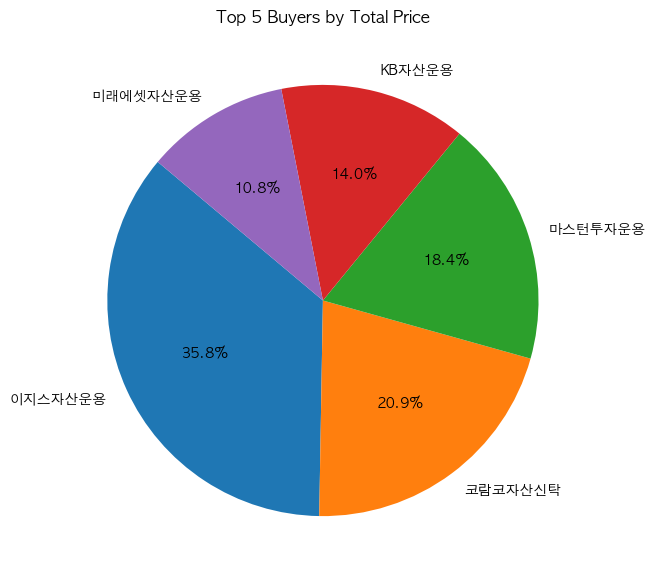

In [56]:
buyer_price_sum = market_market_.groupby('buyer_name')['price'].sum()

top_5_buyers = buyer_price_sum.nlargest(5)


plt.figure(figsize=(10, 7))
plt.pie(top_5_buyers, labels=top_5_buyers.index, autopct='%1.1f%%', startangle=140)
plt.title('Top 5 Buyers by Total Price')
plt.show()

4.1. Buyer별 거래총액 순위: 상업용 부동산 전체 거래액 기준 가장 높은 기업은 이지스자산운용(당사)이며 코람코자산신탁, 마스턴투자운용이 그 뒤를 따른다. 3개 상위사 비중은 70%를 넘는다

In [57]:
market_market_['year'] = pd.to_datetime(market_market_['contract_date'], format='%Y%m%d').dt.year


yearly_sum = market_market_.groupby(['year', 'buyer_name'])['price'].sum().reset_index()


total_yearly_price = yearly_sum.groupby('year')['price'].sum().reset_index()
total_yearly_price.columns = ['year', 'total_price']


our_yearly_price = yearly_sum[yearly_sum['buyer_name'] == '이지스자산운용']
our_yearly_price = our_yearly_price[['year', 'price']]
our_yearly_price.columns = ['year', 'igis_traded_price']

# 6. 연도별 시장 점유율 계산
market_share_df = pd.merge(total_yearly_price, our_yearly_price, on='year', how='left')
market_share_df['igis_traded_price'] = market_share_df['igis_traded_price'].fillna(0)  # NaN을 0으로 대체
market_share_df['market_share_percentage'] = (market_share_df['igis_traded_price'] / market_share_df['total_price']) * 100



market_share_df['total_price'] = market_share_df['total_price'].apply(lambda x: f"{int(x):,}")
market_share_df['igis_traded_price'] = market_share_df['igis_traded_price'].apply(lambda x: f"{int(x):,}")
market_share_df['market_share_percentage'] = market_share_df['market_share_percentage'].apply(lambda x: f"{x:.2f}%")


market_share_df = market_share_df[['year', 'total_price', 'igis_traded_price', 'market_share_percentage']]
market_share_df = market_share_df.sort_values('year').reset_index(drop=True)
market_share_df

,year,total_price,igis_traded_price,market_share_percentage
0,2005,"91,000,000,000",0,0.00%
1,2006,"1,336,947,000,000",0,0.00%
2,2007,"2,080,859,394,330",0,0.00%
3,2008,"1,377,227,123,540",0,0.00%
4,2009,"1,519,301,463,230",0,0.00%
5,2010,"6,050,129,513,343","144,996,000,000",2.40%
6,2011,"10,328,998,332,745","257,000,000,000",2.49%
7,2012,"10,007,445,029,010","1,912,340,621,180",19.11%
8,2013,"12,737,321,820,660","1,305,936,000,000",10.25%
9,2014,"8,606,178,378,147","862,800,000,000",10.03%


4.1. 당사 마켓쉐어: 당사가 2010년 상업용부동산 거래를 했을 때 연도별 2.4%를 기록하여 처음 등장하였으며, 2012년도 약 2조원의 거래금액을 기록하며 당해 총 거래 금액의 20%정도를 차지하게 되었다. 그후 2017년까지 거래액기준 MS 10%를 유지하였다. 2022년도에는 전년대비 전체 상업용부동산 거래액이 줄었음에도 당사는 1.9조 거래액을 기록하며 10%를 다시 기록하기에 이른다